In [23]:
import os
import numpy as np
import pandas as pd
import collections

import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
import scipy.sparse as sp
import random

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Reshape, Add, Activation, Lambda, Dropout, Multiply
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam, SGD
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

    DATA EXPLORATION

In [11]:
data = pd.read_csv("C:/Users/nataa/OneDrive/Pulpit/spoti/spotify/prepared_spotify_data.csv", on_bad_lines = 'skip')

data.columns = data.columns.str.replace('"', '')
data.columns = data.columns.str.replace(' ', '')

The original dataset is quite large - it consists of 12 891 680 rows. First of all, let's check how many users and artists are in the dataset.

In [12]:
usersCount = len(pd.unique(data['user_id']))
artistsCount = len(pd.unique(data['artistname']))
print("Number of users:", usersCount, "\nNumber of artists:", artistsCount)

Number of users: 15918 
Number of artists: 289779


Then I check the artists most frequently appearing in users' playlists along with their frequency of appearance.

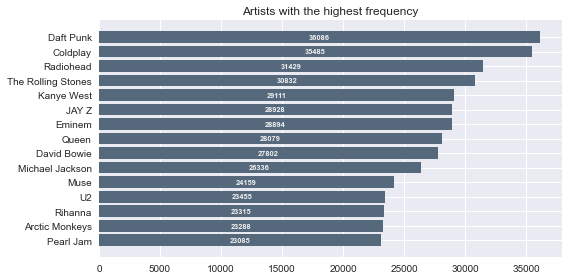

In [13]:
artistsFreq = data['artistname'].value_counts()
artistsFreq = pd.DataFrame(artistsFreq).reset_index()
artistsFreq = artistsFreq.head(15)
artistsFreq.rename(columns = {'index':'Artist', 'artistname':'Frequency'}, 
                   inplace = True)

artist = artistsFreq['Artist']
frequency = artistsFreq['Frequency']
plt.style.use('seaborn')
plt.rcParams.update({'figure.autolayout': True})
bPlot, ax = plt.subplots(figsize = (8, 4))
bars = ax.barh(artist, frequency, color = '#56687C')
ax.bar_label(bars, label_type = 'center', color = '#EFF0F0', 
             fontsize = 7.5, fontweight = 'bold')
ax.set(title = 'Artists with the highest frequency')
ax.invert_yaxis()
plt.show()

In the last step, let's check how many users have less than 20 artists in playlists, and also - how many artists appear in the dataset less than 50 times.

In [14]:
usersFreq = data['user_id'].value_counts()
usersFreq = pd.DataFrame(usersFreq).reset_index()
usersFreq.rename(columns = {'index':'User_id', 'user_id':'Frequency'}, inplace = True)
frequency = usersFreq['Frequency']
usersCount = frequency[frequency < 20].count()

print("Number of users with less than 20 artists in playlists:", usersCount)

Number of users with less than 20 artists in playlists: 1615


In [15]:
artistsFreq = data['artistname'].value_counts()
artistsFreq = pd.DataFrame(artistsFreq).reset_index()
artistsFreq.rename(columns = {'index':'Artist', 'artistname':'Frequency'}, inplace = True)
frequency = artistsFreq['Frequency']

artistsCount = frequency[frequency < 100].count()

print("Number of artists who appear less than 100 times:", artistsCount)

Number of artists who appear less than 100 times: 275533


    DATA PREPARATION AND MAKING AN INSTANCE OF THE MODEL

After I'd changed columns' names, I decided to only keep artists with frequency of 100 or more, and users who have at least 20 artists in their playlists to lessen the impact of cold start problem. Cold start problem is also known as the lack of information problem. When the new user enter in the system, we don’t have sufficient information of user's profile and his/her preference for particular artists.

In [16]:
data.rename(columns = {'user_id':'user_id', 'artistname':'artist_name', 
                       'trackname':'track_name', 'playlistname':'playlist_name'}, 
                       inplace = True)

In [17]:
data = data.groupby('artist_name').filter(lambda x : len(x) >= 100)
data = data.groupby('user_id').filter(lambda x : len(x) >= 20)

I randomly select 50% of the rows.

In [18]:
data = data.sample(frac = 0.05)

In [10]:
print(data.shape)

(532595, 4)


In the next step I turn artists into their unique cat codes so I can get a 0-N index for artists.

In [19]:
data['artistindex'] = data['artist_name'].astype('category').cat.codes
print(len(data['artistindex'].unique()))
print(data.head())

14232
         user_id   artist_name  \
57747         69          Muse   
7151503     8682     Girl Talk   
4780270     6137  Bessie Smith   
6887984     8325      Bee Gees   
2161343     2907    Pink Floyd   

                                             track_name  \
57747                                Stockholm Syndrome   
7151503                                     Give And Go   
4780270  Jazzbo Brown from Memphis Town - 78rpm Version   
6887984        Stayin' Alive (Remastered Album Version)   
2161343      Astronomy Domine - 2011 Remastered Version   

                                             playlist_name  artistindex  
57747    június 5. 2015. / Rock in Vienna - Festival Da...         8579  
7151503                                            Starred         4670  
4780270                                         BLUESWOMEN         1239  
6887984                                           classics         1153  
2161343                                  Psychedelic Salad      

Now I split my data into training and testing sets. 

In [20]:
train, test = train_test_split(data, random_state = 42, test_size = 0.2)

After that, I'm creating a sparse user_id x artistindex matrix, where mat[i, j] = 1 if an user_id i has artist j.

In [13]:
train_matrix = sp.dok_matrix((train.shape[0],
                              len(data['artistindex'].unique())), 
                              dtype = np.float32)
for user_id, artistindex in zip(train['user_id'], train['artistindex']):
    train_matrix[user_id, artistindex] = 1.0

And then, I'm making an instance of the model.

In [14]:
def get_model(num_users, num_artists, latent_dim = 8, dense_layers = [64, 32, 16, 8], reg_layers = [0, 0, 0, 0], reg_gmf = 0):

    user_input = Input(shape=(1,), dtype = 'int32', name = 'user_input')
    artist_input = Input(shape=(1,), dtype = 'int32', name = 'artist_input')

    gmf_user_embedding = Embedding(input_dim = num_users, 
                         output_dim = latent_dim,
                         name = 'gmf_user_embedding',
                         embeddings_initializer = 'RandomNormal',
                         embeddings_regularizer = l2(reg_gmf), 
                         input_length = 1)

    gmf_artist_embedding = Embedding(input_dim = num_artists, 
                         output_dim = latent_dim,
                         name = 'gmf_artist_embedding',
                         embeddings_initializer ='RandomNormal',
                         embeddings_regularizer = l2(reg_gmf), 
                         input_length = 1)

    mlp_user_embedding = Embedding(input_dim = num_users, 
                         output_dim = int(dense_layers[0]/2),
                         name = 'mlp_user_embedding',
                         embeddings_initializer = 'RandomNormal',
                         embeddings_regularizer = l2(reg_layers[0]), 
                         input_length = 1)

    mlp_artist_embedding = Embedding(input_dim = num_artists, 
                         output_dim = int(dense_layers[0]/2),
                         name = 'mlp_artist_embedding',
                         embeddings_initializer = 'RandomNormal',
                         embeddings_regularizer = l2(reg_layers[0]), 
                         input_length = 1)

    gmf_user_vector = Flatten()(gmf_user_embedding(user_input))
    gmf_artist_vector = Flatten()(gmf_artist_embedding(artist_input))
    gmf_vector = Multiply()([gmf_user_vector, gmf_artist_vector])

    mlp_user_vector = Flatten()(mlp_user_embedding(user_input))
    mlp_artist_vector = Flatten()(mlp_artist_embedding(artist_input))
    mlp_vector = Concatenate()([mlp_user_vector, mlp_artist_vector])
    
    for i in range(1, len(dense_layers)):
        layer = Dense(dense_layers[i],
                      activity_regularizer = l2(reg_layers[i]),
                      activation = 'relu',
                      name = 'layer_%i' % i)
        mlp_vector = layer(mlp_vector)

    predict_layer = Concatenate()([gmf_vector, mlp_vector])

    result = Dense(1, activation = 'sigmoid',
                   kernel_initializer = 'lecun_uniform', 
                   name = 'result')

    model = Model(inputs = [user_input, artist_input], 
                  outputs = result(predict_layer))

    return model

Then I'm going back to my training set. We only know which artists appear in each users' playlists, so there is a natural scarcity of negative feedback in playlist recommendation. To solve this problem, I generate user-artist pairs that are not valid.

In [15]:
def get_train_samples(train_matrix, negative_instances):
    user_input, artist_input, labels = [], [], []
    num_user, num_artist = train_matrix.shape
    for (user, artist) in train_matrix.keys():
        user_input.append(user)
        artist_input.append(artist)
        labels.append(1)
        for i in range(negative_instances):
            random_artist = np.random.randint(num_artist)
            while (user, random_artist) in train_matrix.keys():
                random_artist = np.random.randint(num_artist)
            user_input.append(user)
            artist_input.append(random_artist)
            labels.append(0)
    return user_input, artist_input, labels

After that, I can finally make an instance of the model.

In [16]:
loaded = True

latent_dim = 8
dense_layers = [64, 32, 16, 8]
reg_layers = [0, 0, 0, 0]
reg_gmf = 0
negative_instances = 4

num_users, num_artists = train_matrix.shape

model = get_model(num_users, num_artists, latent_dim, dense_layers, reg_layers, reg_gmf)

model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 artist_input (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 mlp_user_embedding (Embedding)  (None, 1, 32)       13634432    ['user_input[0][0]']             
                                                                                                  
 mlp_artist_embedding (Embeddin  (None, 1, 32)       455616      ['artist_input[0][0]']           
 g)                                                                                           

    TRAINING THE MODEL

After I'd generated training instances, I trained my model for 10 epochs and I got an accuracy of 0.9556 with loss of 0.1149, using only 50% of the data.

In [17]:
user_input, artist_input, labels = get_train_samples(train_matrix, negative_instances)

history = model.fit([np.array(user_input), np.array(artist_input)], np.array(labels),
                    batch_size = 256, epochs = 10, verbose = 1, shuffle = True)

Epoch 1/10
5674/5674 [==============================] - 931s 163ms/step - loss: 0.3873 - accuracy: 0.8414
Epoch 2/10
5674/5674 [==============================] - 915s 161ms/step - loss: 0.3502 - accuracy: 0.8541
Epoch 3/10
5674/5674 [==============================] - 982s 173ms/step - loss: 0.2955 - accuracy: 0.8768
Epoch 4/10
5674/5674 [==============================] - 948s 167ms/step - loss: 0.2566 - accuracy: 0.8928
Epoch 5/10
5674/5674 [==============================] - 936s 165ms/step - loss: 0.2247 - accuracy: 0.9069
Epoch 6/10
5674/5674 [==============================] - 942s 166ms/step - loss: 0.1968 - accuracy: 0.9194
Epoch 7/10
5674/5674 [==============================] - 869s 153ms/step - loss: 0.1720 - accuracy: 0.9306
Epoch 8/10
5674/5674 [==============================] - 931s 164ms/step - loss: 0.1503 - accuracy: 0.9403
Epoch 9/10
5674/5674 [==============================] - 1063s 187ms/step - loss: 0.1311 - accuracy: 0.9485
Epoch 10/10
5674/5674 [======================

In [18]:
model_file = 'recommendation_system.h5'
model.save(model_file, overwrite = True)

Now that I've trained and saved my model, I'm ready to recommend artists for my users.

In [9]:
model_path = 'recommendation_system.h5'
model = load_model(model_path)

In [21]:
predictions = model.predict([test.user_id, test.artistindex])
length = len(predictions)

3329/3329 [==============================] - 16s 4ms/step


In [25]:
recommendations_df = pd.DataFrame(np.nan, index = range(length), 
                                  columns=['user_id', 'artist_name', 'prediction'])

for i in range(0, length):
    recommendations_df.loc[i] = (test.user_id.iloc[i], test.artist_name.iloc[i], predictions[i])

recommendations_df = recommendations_df.sort_values(by = ['prediction'], ascending = False)

recommendations_df = recommendations_df.astype({'user_id':'int'})

print(recommendations_df.head(30))

       user_id                      artist_name  prediction
22232     1462                      Against Me!    1.000000
75561     1462                      Against Me!    1.000000
94718     4835                     Alan Jackson    1.000000
8564      1462                      Against Me!    1.000000
48172     1462                      Against Me!    1.000000
93379     5429                       Commodores    1.000000
48157     1462                    Alkaline Trio    1.000000
89087     1462                    Alkaline Trio    1.000000
22596     5429                       Commodores    1.000000
38183     7577                  Hillsong United    1.000000
71360     8493                       Supertramp    1.000000
19282    15906                     Andrew Bayer    1.000000
41915     1154                   Da' T.R.U.T.H.    1.000000
92674    10890                            Meiko    1.000000
20135      682                    Alkaline Trio    0.999999
45280     7683                   Alejand